In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
from skimage import feature
import scipy

In [3]:
df = pd.read_csv('../data/train_logs.csv')
df['pos'] = df['cursor_position']% 10
df['line'] = (df['cursor_position']/10).astype(int)

In [119]:
# Optimize the function to calculate top N frequencies and their magnitudes for each 'id' using groupby and apply
def calculate_fft_features(group):

    from scipy.optimize import curve_fit
    from scipy.signal import savgol_filter

    def exponential_decay(t, A, B, C):
        return A * np.exp(-B * t) + C

    group['pos'] = group['cursor_position']%30
    group['line'] = (group['cursor_position']/30).astype(int)

    # Perform Fourier Transform on 'pos'
    fft_values = fft(group['pos'])[1:]
    
    # Generate frequencies corresponding to the Fourier Transform values
    frequencies = np.fft.fftfreq(len(fft_values), 1)[1:]
    
    # Take absolute value to get magnitude
    fft_magnitude = np.abs(fft_values)
    
    # Identify indices where the frequencies are positive
    positive_indices = np.where(frequencies > 0)[0]
    
    # Filter out only positive frequencies and skip the zero frequency
    frequencies = frequencies[positive_indices]
    magnitudes = fft_magnitude[positive_indices]
    
    # Frequency Domain Features
    peak_freq = frequencies[np.argmax(magnitudes)]
    mean_freq = np.average(frequencies, weights=magnitudes)
    median_freq = frequencies[len(magnitudes) // 2]
    bandwidth = np.ptp(frequencies)
    freq_skewness = scipy.stats.skew(magnitudes)
    freq_kurtosis = scipy.stats.kurtosis(magnitudes)

    # Other Features
    total_energy = np.sum(magnitudes ** 2)
    
    # Spectral Entropy
    psd_norm = np.abs(magnitudes) / np.sum(np.abs(magnitudes))
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps))
    
    # Spectral Flatness
    spectral_flatness = np.exp(np.mean(np.log(magnitudes + np.finfo(float).eps))) / np.mean(magnitudes)
    
    # Spectral Roll-off
    spectral_sum = np.cumsum(magnitudes)
    spectral_rolloff = frequencies[np.searchsorted(spectral_sum, 0.85 * spectral_sum[-1])]
    
    # Statistical Features
    mean_amplitude = np.mean(magnitudes)
    std_amplitude = np.std(magnitudes)
    skew_amplitude = scipy.stats.skew(magnitudes)
    kurtosis_amplitude = scipy.stats.kurtosis(magnitudes)

    # Fit curve to FFT
    try:
        popt, pcov = curve_fit(exponential_decay, frequencies, savgol_filter(magnitudes, 30, 3))
        A, B, C = popt
    except:
        A, B, C = 0, 0, 0
    

    features = {
        "Fit Amplitude": A,
        "Fit Decay": B,
        "Fit Offset": C,
        # "Magnitudes": magnitudes,
        # "Frequencies": frequencies,
        "Peak Frequency": peak_freq,
        "Mean Frequency": mean_freq,
        "Median Frequency": median_freq,
        "Bandwidth": bandwidth,
        "Frequency Skewness": freq_skewness,
        "Frequency Kurtosis": freq_kurtosis,
        "Total Energy": total_energy,
        "Spectral Entropy": spectral_entropy,
        "Spectral Flatness": spectral_flatness,
        "Spectral Roll-off": spectral_rolloff,
        "Mean Amplitude": mean_amplitude,
        "Std Amplitude": std_amplitude,
        "Skew Amplitude": skew_amplitude,
        "Kurtosis Amplitude": kurtosis_amplitude
    }
    
    return pd.Series(features)

In [120]:
# Use groupby and apply to optimize the calculation
result = df.groupby('id').apply(calculate_fft_features).reset_index()

In [16]:
image = np.array(result.loc[0]['Magnitudes'])

contrast_manual = np.mean(np.abs(np.diff(image)))

# 5. Image Moments
# We'll use numpy and scipy.stats to calculate statistical moments
mean_moment_manual = np.mean(image)
variance_moment_manual = np.var(image)
skewness_moment_manual = scipy.stats.skew(image)
kurtosis_moment_manual = scipy.stats.kurtosis(image)

contrast_manual, mean_moment_manual, variance_moment_manual, skewness_moment_manual, kurtosis_moment_manual

(173.74174678402966,
 292.5810629064662,
 110711.79694169032,
 3.90752433963456,
 25.219347126389096)

In [32]:
# idx = 0
# plt.plot(df.loc[idx]['frequencies'], df.loc[idx]['magnitudes'])

In [98]:
from scipy.stats import lognorm
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.optimize import curve_fit

In [99]:
def exponential_decay(t, A, B, C):
    return A * np.exp(-B * t) + C

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

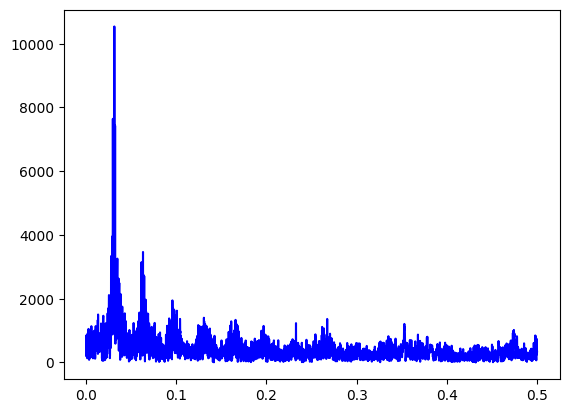

In [130]:
idx = 61

x = result.loc[idx]['Frequencies']
# y = savgol_filter(result.loc[idx]['Magnitudes'], 51, 3)
y = result.loc[idx]['Magnitudes']
plt.plot(x, y, 'b')

popt, pcov = curve_fit(exponential_decay, x, y)#, maxfev=2000)
plt.plot(x, exponential_decay(x, *popt), '-')

plt.show()

In [82]:
peaks

array([ 46,  75,  88,  90,  93,  95, 101, 103, 107, 119, 122, 130, 132,
       136, 138, 140, 145, 148, 150, 155, 165, 168, 171, 175, 178, 182,
       187, 190, 197, 200, 204, 208, 210, 215, 217, 221, 224, 227, 230,
       239, 244, 249, 253, 255, 267, 270, 272, 279, 288, 298, 300, 308,
       311, 322, 324, 326, 333, 342, 347, 350, 354, 357, 360, 365, 367,
       369, 371, 379, 383, 389, 391, 397, 406, 410, 414, 417, 421, 423,
       426, 433, 435, 440, 443, 447, 450, 455, 458, 464, 468, 470, 475,
       480, 482, 489, 493, 497, 499, 503, 517, 528, 533, 539, 544, 550,
       552, 563, 565, 573, 577, 582, 586, 588, 593, 599, 603, 606, 615,
       625, 629, 633, 652, 657, 659, 663, 671, 682, 694, 698, 700, 704,
       706, 718, 729, 732, 734, 737, 746, 750, 752, 757, 761, 765, 767,
       772, 778, 811], dtype=int64)